# Libraries

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from dotenv import load_dotenv
import os
import time
dotenv_path = r'C:\Users\santi\OneDrive\Desktop\Spotify_Popularity\.env.txt'
load_dotenv(dotenv_path)

True

# Api Connection

In [22]:
# Configura tus credenciales de cliente
client_id = os.getenv("SPOTIFY_CLIENT_ID")
client_secret = os.getenv("SPOTIFY_CLIENT_SECRET")
# Autenticación con Spotify
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

# Funciones

In [3]:
def get_playlist_tracks(username,playlist_id):
    results = sp.user_playlist_tracks(username,playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

# Dataframe de Info General del Track

In [4]:
%%time
playlists = ['1M31YfWCBmOSlGGyF0wvsw', '37i9dQZF1DX4KeocBrdbJg', '37i9dQZEVXbMDoHDwVN2tF', '37i9dQZF1DXbvPjXfc8G9S',
             '4KlHX1H41ZIyQ5oodAp2kj', '7xwYHh7KbKDtlMblSkvtfu', '37i9dQZF1DXcBWIGoYBM5M', '6OUqsni7ugc2wWXrX2lloj',
             '5fpfBQeYdgXTy1IC74dbZc', '37i9dQZF1DWVskFRGurTfg', '37i9dQZF1DX7fxXD138pp0', '37i9dQZF1DXb6ejV2Sv22Q', 
             '37i9dQZF1DWXwsJebq0rKg', '37i9dQZF1DX7fwT5VsaHzA', '37i9dQZF1DX8XdqmB6xlX2', '37i9dQZF1DXcuJfJUfXtde', 
             '37i9dQZF1DX0mWZXNs0ArA', '37i9dQZF1DX1SbnWqcjJBz', '37i9dQZF1DXbdNhlZLjJXz', '37i9dQZF1DX8vTpEmKeKvc',
             '37i9dQZF1DX6aTaZa0K6VA', '37i9dQZF1DX14fiWYoe7Oh', '37i9dQZF1DWW46Vfs1oltB', '37i9dQZF1DWYN0zdqzbEwl',
             '37i9dQZF1DWYZ2zzgvJZul', '37i9dQZF1DX6ThddIjWuGT', '37i9dQZF1DX8womvTyUjrN', '37i9dQZF1DX3omIq8ziEt6',
             '37i9dQZF1DX7Qo2zphj7u3', '37i9dQZF1DX1ngEVM0lKrb', '37i9dQZF1DX0rrtMTI2Ff5', '37i9dQZF1DWVCk2se27jFX',
             '37i9dQZF1DXaaU1AaHpZeu', '7gmIaIxJLiY0QDz5RKKPrj', '37i9dQZF1DWSIaDfaHJHox', '0vvXsWCC9xrXsKd4FyS8kM',
             '2cJESIzRKJJXzIBJZ72lyH', '35EN37472tayZcnOnmILSX', '32BTIxZYk6J62gO6m22od1', '2GiJfkoQSvJr5jAISNbPZW',
             '37i9dQZF1DWXRqgorJj26U', '37i9dQZF1DWWQRwui0ExPn', '37i9dQZF1DWWMOmoXKqHTD', '3CBtBLMmqc8FfAOqRRwmuY',
             '37i9dQZF1DWTmvXBN4DgpA', '37i9dQZF1DX4WYpdgoIcn6', '37i9dQZF1DX76Wlfdnj7AP', '37i9dQZF1DWSqmBTGDYngZ']

results = []

for p in playlists:
    results.extend(get_playlist_tracks('31xabdqv7f3ysv2mpypcokrtvsty', p))

CPU times: total: 391 ms
Wall time: 1min 15s


In [5]:
track_ids = []
track_names = []
artists_names = []
popularities = []
duration_ms = []
years = []

for i in range(len(results)):
    track = results[i]['track']
    release_date = track['album']['release_date'] if track['album'] is not None else None
    if release_date is not None:
        track_ids.append(track['id'])
        track_names.append(track['name'])
        artists_names.append(track['artists'][0]['name'])
        popularities.append(track['popularity'])
        duration_ms.append(track['duration_ms'])
        years.append(int(release_date[:4]))
    else:
        track_ids.append(track['id'])
        track_names.append(track['name'])
        artists_names.append(track['artists'][0]['name'])
        popularities.append(track['popularity'])
        duration_ms.append(track['duration_ms'])
        years.append(None)

In [6]:
data = {
    'id': track_ids,
    'name': track_names,
    'artist': artists_names,
    'popularity': popularities,
    'duration_ms': duration_ms,
    'year': years
}

df = pd.DataFrame(data)
df = df[df['id'].notna()]
df = df.drop_duplicates(subset='id').reset_index(drop=True)

In [7]:
df.shape

(11349, 6)

In [8]:
df_intervalo = df[(df['popularity'] >= 0) & (df['popularity'] <= 10)]
df_fuera_intervalo = df[(df['popularity'] < 0) | (df['popularity'] > 10)]

# Seleccionar aleatoriamente la mitad de las filas donde 'popularity' está en el intervalo de 0 a 10
df_intervalo_mitad = df_intervalo.sample(frac=0.5)

# Concatenar los dos dataframes
df_resultado = pd.concat([df_fuera_intervalo, df_intervalo_mitad])

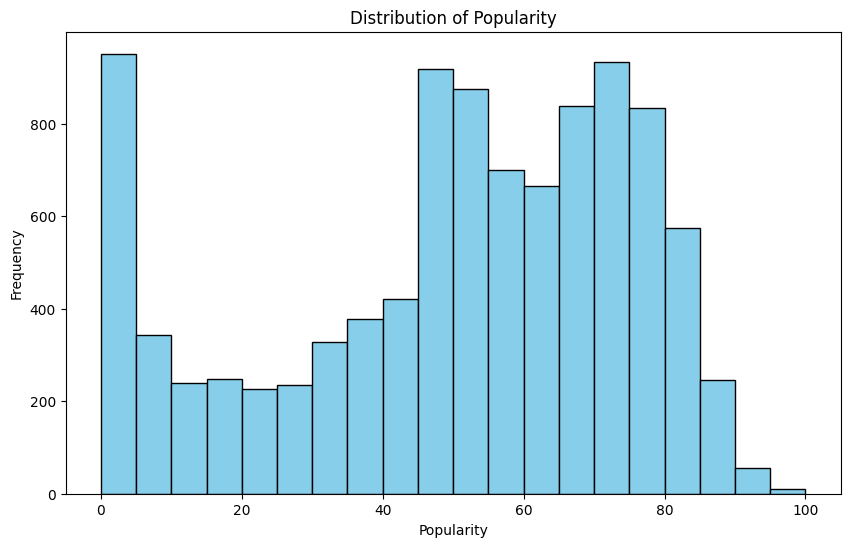

In [9]:
# Crear el histograma
plt.figure(figsize=(10, 6))
plt.hist(df_resultado['popularity'], bins=20, color='skyblue', edgecolor='black')

# Añadir etiquetas y título
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.title('Distribution of Popularity')

# Mostrar el histograma
plt.show()

In [10]:
df_resultado.shape

(10019, 6)

In [13]:
df_resultado = df_resultado.reset_index(drop=True)

In [16]:
df_resultado

,id,name,artist,popularity,duration_ms,year
0,5By7Pzgl6TMuVJG168VWzS,Michelle - Remastered 2009,The Beatles,67,162373,1965.0
1,2kSb3wYSOV996xA2NSmpck,Melting,Kali Uchis,82,208853,2015.0
2,1xYBeQ5u8uaJ3oBWktjGyJ,Acurrucar,Ed Maverick,71,234080,2018.0
3,05HpBFLrHBjWpgV0DSPUAv,Tiroteo,Marc Seguí,66,266290,2021.0
4,2JPLbjOn0wPCngEot2STUS,Yonaguni,Bad Bunny,79,206710,2021.0
...,...,...,...,...,...,...
10014,0EewbyA1HzExGa4xzAsyyW,I Am All,Ron E Shelton,9,301297,2024.0
10015,1VTYFbswCSXU1Sy877pJML,OMW,Pot-Key,1,310714,2024.0
10016,4ue5ET9msGNJSO6sSbrCVE,I Want To Break Free - Remastered 2011,Queen,0,258000,1991.0
10017,5BGsQNTJ79qKuMEPoL5iFd,Hard Times,Marián Lucký,0,225374,2016.0


In [25]:
df_resultado.to_csv('data.csv', index=False)

In [23]:
%%time
import time

# Obtener los ids de las canciones
track_ids = df_resultado['id'].to_list()[:100]
# Definir la función para solicitar los audio_features de un lote de canciones
def obtener_audio_features(ids):
    audio_features = []
    for i in range(0, len(ids), 90):  # Iterar en pasos de 50
        batch_ids = ids[i:i+90]  # Obtener el lote actual
        tracks_features = sp.audio_features(batch_ids)  # Solicitar los audio_features
        audio_features.extend(tracks_features)  # Agregarlos a la lista de audio_features
        time.sleep(90)  # Pausa de dos minutos antes de la siguiente solicitud
    return audio_features

# Llamar a la función para obtener los audio_features de todas las canciones
audio_features = obtener_audio_features(track_ids)

# Convertir la lista de audio_features en un DataFrame
df_audio_features = pd.DataFrame(audio_features)

CPU times: total: 484 ms
Wall time: 3min 1s


In [24]:
df_audio_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.578,0.290,5,-12.501,0,0.0341,0.6520,0.000000,0.1050,0.666,117.403,audio_features,5By7Pzgl6TMuVJG168VWzS,spotify:track:5By7Pzgl6TMuVJG168VWzS,https://api.spotify.com/v1/tracks/5By7Pzgl6TMu...,https://api.spotify.com/v1/audio-analysis/5By7...,162373,4
1,0.574,0.479,8,-7.776,1,0.0355,0.1790,0.080300,0.1060,0.303,115.263,audio_features,2kSb3wYSOV996xA2NSmpck,spotify:track:2kSb3wYSOV996xA2NSmpck,https://api.spotify.com/v1/tracks/2kSb3wYSOV99...,https://api.spotify.com/v1/audio-analysis/2kSb...,208854,4
2,0.809,0.216,8,-12.103,1,0.0353,0.9440,0.007990,0.0894,0.236,99.100,audio_features,1xYBeQ5u8uaJ3oBWktjGyJ,spotify:track:1xYBeQ5u8uaJ3oBWktjGyJ,https://api.spotify.com/v1/tracks/1xYBeQ5u8uaJ...,https://api.spotify.com/v1/audio-analysis/1xYB...,234080,4
3,0.747,0.605,9,-6.633,1,0.0269,0.0548,0.000004,0.0794,0.564,110.402,audio_features,05HpBFLrHBjWpgV0DSPUAv,spotify:track:05HpBFLrHBjWpgV0DSPUAv,https://api.spotify.com/v1/tracks/05HpBFLrHBjW...,https://api.spotify.com/v1/audio-analysis/05Hp...,266291,4
4,0.644,0.648,1,-4.601,1,0.1180,0.2760,0.000000,0.1350,0.440,179.951,audio_features,2JPLbjOn0wPCngEot2STUS,spotify:track:2JPLbjOn0wPCngEot2STUS,https://api.spotify.com/v1/tracks/2JPLbjOn0wPC...,https://api.spotify.com/v1/audio-analysis/2JPL...,206710,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.760,0.703,6,-3.667,1,0.0631,0.3130,0.000000,0.0784,0.739,96.033,audio_features,1kqH58eGh2ZTOHwqBIB2tM,spotify:track:1kqH58eGh2ZTOHwqBIB2tM,https://api.spotify.com/v1/tracks/1kqH58eGh2ZT...,https://api.spotify.com/v1/audio-analysis/1kqH...,243899,4
96,0.773,0.742,5,-3.678,0,0.0460,0.0206,0.000000,0.0754,0.571,114.071,audio_features,0HqZX76SFLDz2aW8aiqi7G,spotify:track:0HqZX76SFLDz2aW8aiqi7G,https://api.spotify.com/v1/tracks/0HqZX76SFLDz...,https://api.spotify.com/v1/audio-analysis/0HqZ...,165265,4
97,0.464,0.417,0,-9.345,0,0.0256,0.1360,0.022000,0.0974,0.479,67.528,audio_features,5XeFesFbtLpXzIVDNQP22n,spotify:track:5XeFesFbtLpXzIVDNQP22n,https://api.spotify.com/v1/tracks/5XeFesFbtLpX...,https://api.spotify.com/v1/audio-analysis/5XeF...,183956,4
98,0.537,0.421,5,-8.720,1,0.0285,0.8270,0.000000,0.1380,0.524,98.224,audio_features,2HafqoJbgXdtjwCOvNEF14,spotify:track:2HafqoJbgXdtjwCOvNEF14,https://api.spotify.com/v1/tracks/2HafqoJbgXdt...,https://api.spotify.com/v1/audio-analysis/2Haf...,184061,4
